图形示例及参考来源：
Duan, H., Chen, S. & Song, J. Characterizing regional building energy consumption under joint climatic and socioeconomic impacts. Energy 245, 123290 (2022).

图形传递的信息：
将地图按照某个类型进行划分
每个划分依据中显示该划分类型的某些特征
饼状图显示该特征单一年份的静态组合; 柱状图显示该特征时间序列变化

示例：
以“不同ssp情景下中国不同气候区住宅建筑HVAC系统在关键年份的类型组成及市场占比变化”为例进图形绘制

中国行政区划底图准备：
国家地理信息公共服务平台，网址：https://www.tianditu.gov.cn
下载导航：服务中心-数据资源-行政区划可视化
审图号：GS（2024）0650号

为中国_县.geojson中的各县添加所属的市和省属性，方便行政区域的合并

In [1]:
import geopandas as gpd
import re
import pandas as pd

# 读取.geojson文件
province = gpd.read_file(r'E:\dmy_file\China climate hvac\map_shap\China\中国_省.geojson')
city = gpd.read_file(r'E:\dmy_file\China climate hvac\map_shap\China\中国_市.geojson')
county = gpd.read_file(r'E:\dmy_file\China climate hvac\map_shap\China\中国_县.geojson')

# 为县级行政区划新建两个属性列
county['province_attr'] = None
county['city_attr'] = None

# 叠加操作，将省、市的属性添加到县
for i, county_row in county.iterrows():
    # 查找省边界包含县边界的情况
    province_match = province[province.contains(county_row.geometry)]
    if not province_match.empty:
        # 将省的属性字典转换为字符串并复制到县的province_attr列
        county.at[i, 'province_attr'] = str(province_match.iloc[0].to_dict())
    
    # 查找市边界包含县边界的情况
    city_match = city[city.contains(county_row.geometry)]
    if not city_match.empty:
        # 将市的属性字典转换为字符串并复制到县的city_attr列
        county.at[i, 'city_attr'] = str(city_match.iloc[0].to_dict())

# 定义一个提取'name'值的函数
def extract_name(attr):
    if pd.isnull(attr):
        return None
    match = re.search(r"'name':\s*'([^']*)'", attr)
    return match.group(1) if match else None

# 应用函数到'province_attr'和'city_attr'列
county['province_name'] = county['province_attr'].apply(extract_name)
county['city_name'] = county['city_attr'].apply(extract_name)

# 删除原始的'province_attr'和'city_attr'列
county.drop(columns=['province_attr', 'city_attr'], inplace=True)

# 保存更新后的县级行政区划文件
county.to_file(r'E:\dmy_file\China climate hvac\map_shap\China\中国_县_更新_cleaned.geojson', driver='GeoJSON')

print("完成叠加属性、提取并保存")


完成叠加属性、提取并保存


合并某些没有数据的县到市

In [2]:
import geopandas as gpd
import pandas as pd

# 读取 .geojson 文件
county = gpd.read_file(r'E:\dmy_file\China climate hvac\map_shap\China\中国_县_更新_cleaned.geojson')

# 过滤出 'province_name' 为 '四川省' 或 '广西壮族自治区' 的行
filtered_county = county[(county['province_name'] == '四川省') | (county['province_name'] == '广西壮族自治区') | (county['province_name'] == '河北省')| (county['province_name'] == '河南省')| (county['province_name'] == '湖南省')| (county['province_name'] == '吉林省')| (county['province_name'] == '辽宁省')| (county['province_name'] == '新疆维吾尔自治区')]

# 合并 'city_name' 相同的图块，保留第一个 'gb' 的值
dissolved = filtered_county.dissolve(by='city_name', as_index=False, aggfunc={
    'gb': 'first',
    'province_name': 'first'
})

# 将 'city_name' 的值赋给 'name' 列
dissolved['name'] = dissolved['city_name']


# 将原来的 DataFrame 中 'province_name' 为 '四川省' 或 '广西壮族自治区' 的部分替换为合并后的数据
county = pd.concat([county[~county['province_name'].isin(['四川省', '广西壮族自治区', '河北省', '河南省', '湖南省', '吉林省', '辽宁省', '新疆维吾尔自治区'])], dissolved], ignore_index=True)

# 保存结果
county.to_file(r'E:\dmy_file\China climate hvac\map_shap\China\中国_县_更新_merged_new.geojson', driver='GeoJSON')

print("合并操作完成并保存")



合并操作完成并保存


关键键匹配：自己数据中代表县/市的“code”与天地图中代表县/市的“gb”进行映射

In [3]:
import pandas as pd
import geopandas as gpd

# 读取Excel文件的'sheet2'工作表中的'gb'和'code'列
excel_data = pd.read_excel(r'E:\dmy_file\China climate hvac\1.xlsx', sheet_name='Sheet2', usecols=['gb', 'code'])

# 确保'gb'列的数据类型为字符串（object）
excel_data['gb'] = excel_data['gb'].astype(str)

# 读取GeoJSON文件
geojson_data = gpd.read_file(r'E:\dmy_file\China climate hvac\map_shap\China\中国_县_更新_merged.geojson')

# 确保GeoJSON数据中的'gb'列的数据类型为字符串（object）
geojson_data['gb'] = geojson_data['gb'].astype(str)

# 将Excel中的数据与GeoJSON中的数据根据'gb'进行合并
merged_data = geojson_data.merge(excel_data, on='gb', how='left')

# 保存更新后的GeoJSON文件
merged_data.to_file(r'E:\dmy_file\China climate hvac\map_shap\China\中国_县_更新_merged_with_code.geojson', driver='GeoJSON')

print("GeoJSON文件已更新并保存")


GeoJSON文件已更新并保存


将自己的数据根据编码映射到geojson文件中

In [4]:
import pandas as pd
import geopandas as gpd

# 读取CSV文件的所有列
csv_data = pd.read_csv(r'E:\dmy_file\China climate hvac\Information of 1872 cities.csv')

# 确保'code'列的数据类型为字符串（object）
csv_data['code'] = csv_data['code']#.astype(str)

# 读取GeoJSON文件
geojson_data = gpd.read_file(r'E:\dmy_file\China climate hvac\map_shap\China\中国_县_更新_merged_with_code.geojson')

# 确保GeoJSON数据中的'code'列的数据类型为字符串（object）
geojson_data['code'] = geojson_data['code']#.astype(int)

# 将CSV中的数据与GeoJSON中的数据根据'code'进行合并
# 这里我们使用'left_on'和'right_on'参数来指定合并的键
merged_data = geojson_data.merge(csv_data, on='code', how='left')

# 保存更新后的GeoJSON文件
merged_data.to_file(r'E:\dmy_file\China climate hvac\map_shap\China\中国_县_更新_merged_with_all_attributes.geojson', driver='GeoJSON')

print("GeoJSON文件已更新并保存")


GeoJSON文件已更新并保存


根据气候区，绘制hvac系统的分布图

d:\anaconda3\envs\environment-jupter\lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: driver ESRI Shapefile does not support open option ENCODINGS
  return ogr_read(


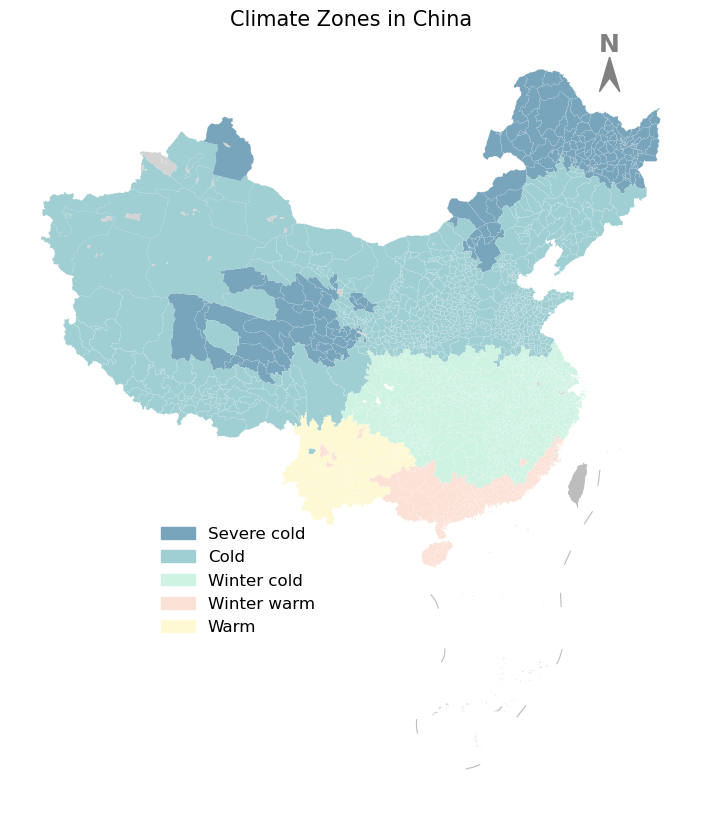

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from palettable.colorbrewer.diverging import RdBu_8_r
from palettable.colorbrewer.sequential import Greys_9
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import os
from matplotlib.patches import Patch
from matplotlib.patches import FancyArrowPatch

# 读取 GeoJSON 文件
china = gpd.read_file(r'E:\dmy_file\China climate hvac\map_shap\gangaotai.shp')#这是包括港澳台的底图
nine_lines= gpd.read_file(r'E:\dmy_file\China climate hvac\map_shap\十段线.shp',encodings='utf-8')
geojson_data = gpd.read_file(r'E:\dmy_file\China climate hvac\map_shap\China\中国_县_更新_merged_with_all_attributes.geojson')

china = china.to_crs(crs='EPSG:2381')
nine_lines = nine_lines.to_crs(crs='EPSG:2381')
geojson_data = geojson_data.to_crs(crs='EPSG:2381')



# 定义颜色映射
color_map = {
    'severe cold A': '#78A5BC',
    'severe cold B': '#78A5BC',
    'severe cold C': '#9FCFD3',
    'cold A': '#9FCFD3',
    'cold B': '#9FCFD3',
    'winter cold': '#CEF3E2',
    'winter warm': '#FCE1D6',
    'warm': '#FEF9D3'
}

# 将 NaN 值映射为默认颜色灰色
geojson_data['color'] = geojson_data['climate_zone'].map(color_map).fillna('#D3D3D3')

# 绘制地图
fig, ax = plt.subplots(figsize=(10, 10))

geojson_data.plot(ax=ax, color=geojson_data['color'], edgecolor='white', linewidth=0.05)
###增加十段线
ax= nine_lines.plot(ax=ax,color=Greys_9.mpl_colors[3],linewidth=0.8)#加十段线
####增加底图
ax = china.plot(ax=ax,color=Greys_9.mpl_colors[3], edgecolor=Greys_9.mpl_colors[0])#底图的框架

# 添加标题
plt.title('Climate Zones in China', fontsize=15)



# # 隐藏坐标轴
# 创建图例条目
legend_items = [
    Patch(color='#78A5BC', label='Severe cold'),
    Patch(color='#9FCFD3', label='Cold'),
    Patch(color='#CEF3E2', label='Winter cold'),
    Patch(color='#FCE1D6', label='Winter warm'),
    Patch(color='#FEF9D3', label='Warm')
]

# 添加图例
ax.legend(handles=legend_items, loc='lower left', frameon=False, fontsize=12,
          bbox_to_anchor=(0.2, 0.2))#, labelspacing=2
# 隐藏坐标轴
ax.set_axis_off()

# 添加指北针
def add_north(ax, labelsize=18, loc_x=0.88, loc_y=1.125, width=0.03, height=0.045, pad=0.2):
    """
    画一个比例尺带'N'文字注释
    主要参数如下
    :param ax: 要画的坐标区域 Axes实例 plt.gca()获取即可
    :param labelsize: 显示'N'文字的大小
    :param loc_x: 以文字下部为中心的占整个ax横向比例
    :param loc_y: 以文字下部为中心的占整个ax纵向比例
    :param width: 指南针占ax比例宽度
    :param height: 指南针占ax比例高度
    :param pad: 文字符号占ax比例间隙
    :return: None
    """
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    left = [minx + xlen*(loc_x - width*.5), miny + ylen*(loc_y - pad)]
    right = [minx + xlen*(loc_x + width*.5), miny + ylen*(loc_y - pad)]
    top = [minx + xlen*loc_x, miny + ylen*(loc_y - pad + height)]
    center = [minx + xlen*loc_x, left[1] + (top[1] - left[1])*.4]
    triangle = mpatches.Polygon([left, top, right, center], color='gray')
    ax.text(s='N',
            x=minx + xlen*loc_x,
            y=miny + ylen*(loc_y - pad + height),
            fontsize=labelsize,
            color='gray', 
            weight = 'bold',
            horizontalalignment='center',
            verticalalignment='bottom')
    ax.add_patch(triangle)

ax = plt.gca()
add_north(ax)

# 添加比例尺

# def add_scalebar(lon0,lat0,length):
    
#     # # style 3
#     # plt.hlines(y=lat0,  xmin = lon0, xmax = lon0+length/111, colors="black", ls="-", lw=1, label='%d km' % (length))
#     # plt.vlines(x = lon0, ymin = lat0-0.45, ymax = lat0+0.45, colors="black", ls="-", lw=1)
#     # plt.vlines(x = lon0+length/2/111, ymin = lat0-0.45, ymax = lat0+0.45, colors="black", ls="-", lw=1)
#     # plt.vlines(x = lon0+length/111, ymin = lat0-0.45, ymax = lat0+0.45, colors="black", ls="-", lw=1)
#     # plt.text(lon0+length/111,lat0+0.6,'%d' % (length),horizontalalignment = 'center')
#     # plt.text(lon0+length/2/111,lat0+0.6,'%d' % (length/2),horizontalalignment = 'center')
#     # plt.text(lon0,lat0+0.6,'0',horizontalalignment = 'center')
#     # plt.text(lon0+length/111/2*3,lat0+0.6,'km',horizontalalignment = 'center')
    
#     # style 1
#     plt.hlines(y=lat0,  xmin = lon0, xmax = lon0+length/111, colors="black", ls="-", lw=2, label='%d km' % (length))
#     plt.vlines(x = lon0, ymin = lat0-0.45, ymax = lat0+0.45, colors="black", ls="-", lw=2)
#     plt.vlines(x = lon0+length/111, ymin = lat0-0.45, ymax = lat0+0.45, colors="black", ls="-", lw=2)
#     plt.text(lon0+length/2/111,lat0+0.45,'500 km',horizontalalignment = 'center')
    
#     # # style 2
#     # plt.hlines(y=lat0,  xmin = lon0, xmax = lon0+length/111, colors="black", ls="-", lw=1, label='%d km' % (length))
#     # plt.vlines(x = lon0, ymin = lat0-0.45, ymax = lat0+0.45, colors="black", ls="-", lw=1)
#     # plt.vlines(x = lon0+length/111, ymin = lat0-0.45, ymax = lat0+0.45, colors="black", ls="-", lw=1)
#     # plt.text(lon0+length/111,lat0+0.7,'%d km' % (length),horizontalalignment = 'center')
#     # plt.text(lon0,lat0+0.7,'0',horizontalalignment = 'center')
# add_scalebar(91,-12.5,1200) # 左下角经度，左下角纬度，比例尺长度

plt.savefig(r'E:\dmy_file\China climate hvac\picture\new{fig_name}_polyon.png'.format(fig_name='climate_zones_HVAC'), dpi=150)
# 显示地图
plt.show()


绘制不同ssp情景下不同时间，城市和农村hvac系统的市场占有率的变化趋势

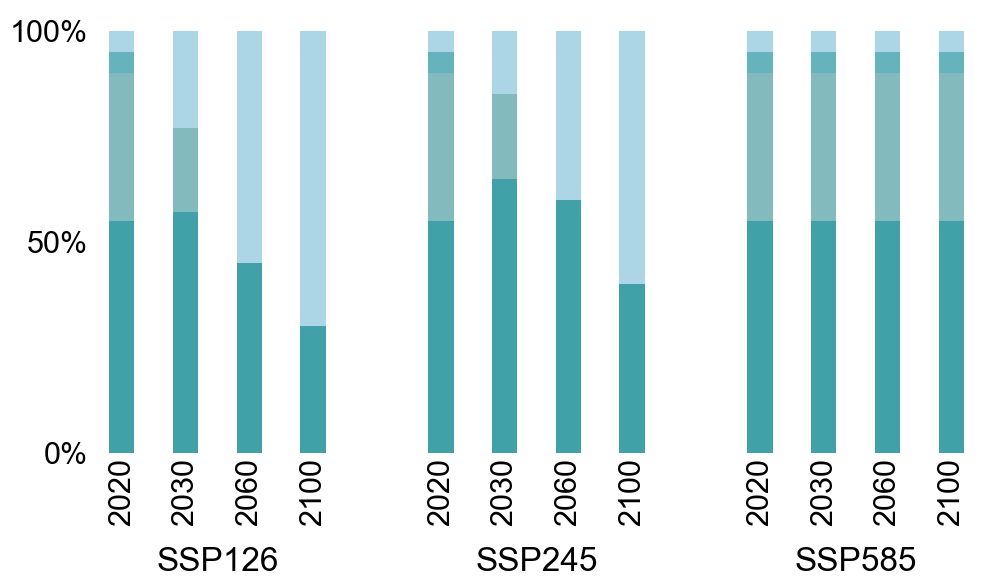

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取Excel文件中的指定范围数据
file_path = r'E:\dmy_file\China climate hvac\marketing_share.xls'
df = pd.read_excel(file_path, sheet_name='data', usecols="B: P", nrows=5)

# 数据处理
x_labels = ['2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100']
categories = df.iloc[:, 0]  # B列为类别
data = df.iloc[:, 1:]       # 剩下的数据为堆积数据

# 将数据转为百分比
data_percent = data.divide(data.sum(axis=0), axis=1) * 100

# 颜色设置
colors = ["#40A1A9", "#82BABE", "#64b3bd", "#ACD6E5"]##A1CED7


# 绘制百分比堆积柱状图
fig, ax = plt.subplots(figsize=(10, 6))
data_percent.T.plot(kind='bar', stacked=True, color=colors, width=0.4, ax=ax)

# 设置y轴
ax.set_yticks([0, 50, 100])
ax.set_yticklabels(['0%', '50%', '100%'], fontname='Arial', fontsize=22)

# 设置x轴和堆积图样式
ax.set_xticklabels(x_labels, fontname='Arial', fontsize=22, rotation=90)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(False)
ax.legend().set_visible(False)
ax.set_frame_on(False)  # 移除边框
ax.tick_params(axis='x', length=0)  # 不显示x轴刻度线
ax.tick_params(axis='y', length=0)  # 不显示y轴刻度线
ax.grid(False)  # 不显示网格线
ax.legend().set_visible(False)  # 不显示图例
ax.set_title('')  # 不显示图表题


# 在x轴下方插入文字
for i, text in enumerate(['SSP126', 'SSP245', 'SSP585']):
    ax.text(1.5 + i * 5, -28, text, ha='center', fontname='Arial', fontsize=24)

# 调整图形布局，向上移动图形内容
plt.subplots_adjust(top=0.95, bottom=0.2)  # 上移内容，bottom 参数越大，内容越上移

plt.savefig(r'E:\dmy_file\China climate hvac\picture\new{fig_name}_polyon.png'.format(fig_name='HVAC_severcold_urban'), dpi=150)

# 显示图形
plt.tight_layout()
plt.show()


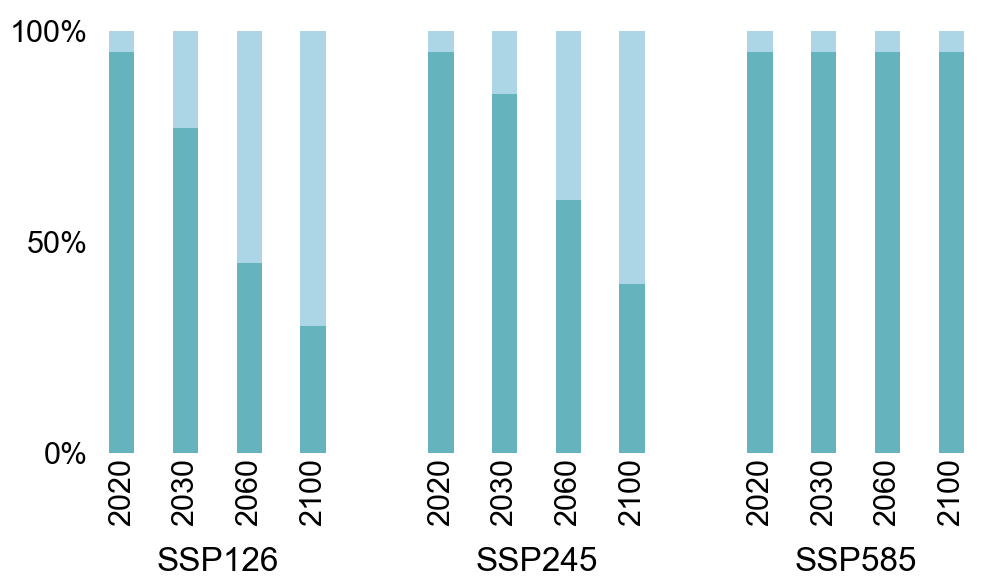

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取Excel文件中的指定范围数据
file_path = r'E:\dmy_file\China climate hvac\marketing_share.xls'
df = pd.read_excel(file_path, sheet_name='data', usecols="R:AF", nrows=3)

# 数据处理
x_labels = ['2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100']
categories = df.iloc[:, 0]  # B列为类别
data = df.iloc[:, 1:]       # 剩下的数据为堆积数据

# 将数据转为百分比
data_percent = data.divide(data.sum(axis=0), axis=1) * 100

# 颜色设置
colors = ["#64b3bd", "#ACD6E5"]#A1CED7


# 绘制百分比堆积柱状图
fig, ax = plt.subplots(figsize=(10, 6))
data_percent.T.plot(kind='bar', stacked=True, color=colors, width=0.4, ax=ax)

# 设置y轴
ax.set_yticks([0, 50, 100])
ax.set_yticklabels(['0%', '50%', '100%'], fontname='Arial', fontsize=22)

# 设置x轴和堆积图样式
ax.set_xticklabels(x_labels, fontname='Arial', fontsize=22, rotation=90)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(False)
ax.legend().set_visible(False)
ax.set_frame_on(False)  # 移除边框
ax.tick_params(axis='x', length=0)  # 不显示x轴刻度线
ax.tick_params(axis='y', length=0)  # 不显示y轴刻度线
ax.grid(False)  # 不显示网格线
ax.legend().set_visible(False)  # 不显示图例
ax.set_title('')  # 不显示图表题


# 在x轴下方插入文字
for i, text in enumerate(['SSP126', 'SSP245', 'SSP585']):
    ax.text(1.5 + i * 5, -28, text, ha='center', fontname='Arial', fontsize=24)
# 调整图形布局，向上移动图形内容
plt.subplots_adjust(top=0.95, bottom=0.2)  # 上移内容，bottom 参数越大，内容越上移

plt.savefig(r'E:\dmy_file\China climate hvac\picture\new{fig_name}_polyon.png'.format(fig_name='HVAC_severcold_rural'), dpi=150)

# 显示图形
plt.tight_layout()
plt.show()


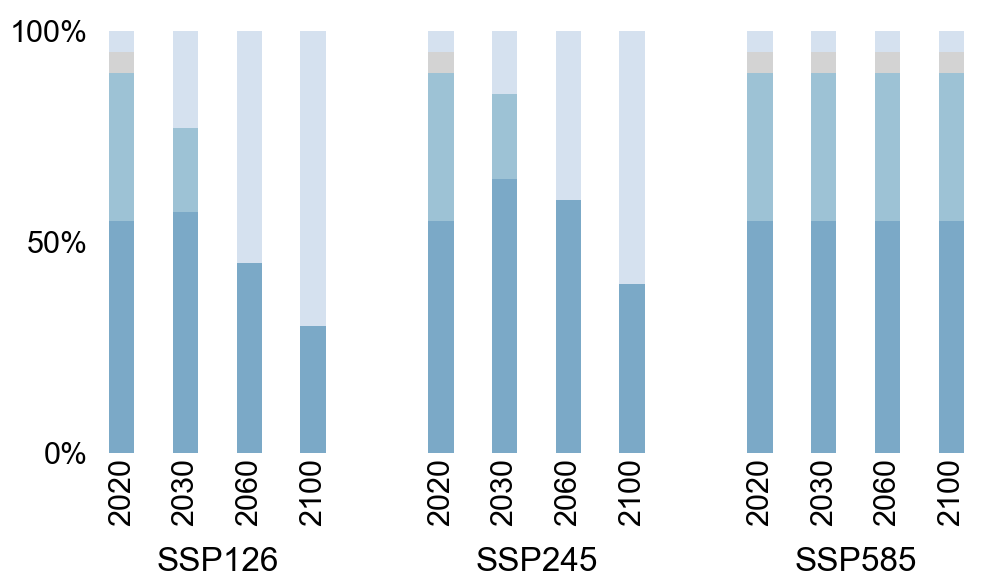

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取Excel文件中的指定范围数据
file_path = r'E:\dmy_file\China climate hvac\marketing_share.xls'
df = pd.read_excel(file_path, sheet_name='data', usecols="B:P", nrows=5, skiprows=6)

# 数据处理
x_labels = ['2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100']
categories = df.iloc[:, 0]  # B列为类别
data = df.iloc[:, 1:]       # 剩下的数据为堆积数据

# 将数据转为百分比
data_percent = data.divide(data.sum(axis=0), axis=1) * 100

# 颜色设置
colors = ["#7BA9C7", "#9DC2D5", "#D3D3D3", "#D5E1EF"]


# 绘制百分比堆积柱状图
fig, ax = plt.subplots(figsize=(10, 6))
data_percent.T.plot(kind='bar', stacked=True, color=colors, width=0.4, ax=ax)

# 设置y轴
ax.set_yticks([0, 50, 100])
ax.set_yticklabels(['0%', '50%', '100%'], fontname='Arial', fontsize=22)

# 设置x轴和堆积图样式
ax.set_xticklabels(x_labels, fontname='Arial', fontsize=22, rotation=90)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(False)
ax.legend().set_visible(False)
ax.set_frame_on(False)  # 移除边框
ax.tick_params(axis='x', length=0)  # 不显示x轴刻度线
ax.tick_params(axis='y', length=0)  # 不显示y轴刻度线
ax.grid(False)  # 不显示网格线
ax.legend().set_visible(False)  # 不显示图例
ax.set_title('')  # 不显示图表题


# 在x轴下方插入文字
for i, text in enumerate(['SSP126', 'SSP245', 'SSP585']):
    ax.text(1.5 + i * 5, -28, text, ha='center', fontname='Arial', fontsize=24)

# 调整图形布局，向上移动图形内容
plt.subplots_adjust(top=0.95, bottom=0.2)  # 上移内容，bottom 参数越大，内容越上移

plt.savefig(r'E:\dmy_file\China climate hvac\picture\new{fig_name}_polyon.png'.format(fig_name='HVAC_cold_urban'), dpi=150)

# 显示图形
plt.tight_layout()
plt.show()


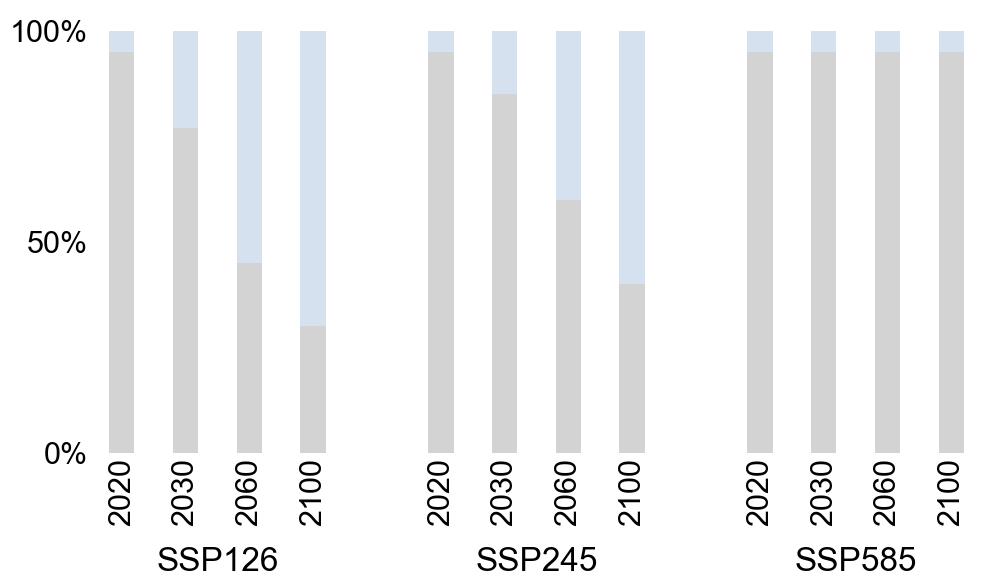

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取Excel文件中的指定范围数据
file_path = r'E:\dmy_file\China climate hvac\marketing_share.xls'
df = pd.read_excel(file_path, sheet_name='data', usecols="R:AF", skiprows=6, nrows=3)

# 数据处理
x_labels = ['2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100']
categories = df.iloc[:, 0]  # B列为类别
data = df.iloc[:, 1:]       # 剩下的数据为堆积数据

# 将数据转为百分比
data_percent = data.divide(data.sum(axis=0), axis=1) * 100

# 颜色设置
colors = ["#D3D3D3", "#D5E1EF"]


# 绘制百分比堆积柱状图
fig, ax = plt.subplots(figsize=(10, 6))
data_percent.T.plot(kind='bar', stacked=True, color=colors, width=0.4, ax=ax)

# 设置y轴
ax.set_yticks([0, 50, 100])
ax.set_yticklabels(['0%', '50%', '100%'], fontname='Arial', fontsize=22)

# 设置x轴和堆积图样式
ax.set_xticklabels(x_labels, fontname='Arial', fontsize=22, rotation=90)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(False)
ax.legend().set_visible(False)
ax.set_frame_on(False)  # 移除边框
ax.tick_params(axis='x', length=0)  # 不显示x轴刻度线
ax.tick_params(axis='y', length=0)  # 不显示y轴刻度线
ax.grid(False)  # 不显示网格线
ax.legend().set_visible(False)  # 不显示图例
ax.set_title('')  # 不显示图表题


# 在x轴下方插入文字
for i, text in enumerate(['SSP126', 'SSP245', 'SSP585']):
    ax.text(1.5 + i * 5, -28, text, ha='center', fontname='Arial', fontsize=24)

# 调整图形布局，向上移动图形内容
plt.subplots_adjust(top=0.95, bottom=0.2)  # 上移内容，bottom 参数越大，内容越上移

plt.savefig(r'E:\dmy_file\China climate hvac\picture\new{fig_name}_polyon.png'.format(fig_name='HVAC_cold_rural'), dpi=150)

# 显示图形
plt.tight_layout()
plt.show()


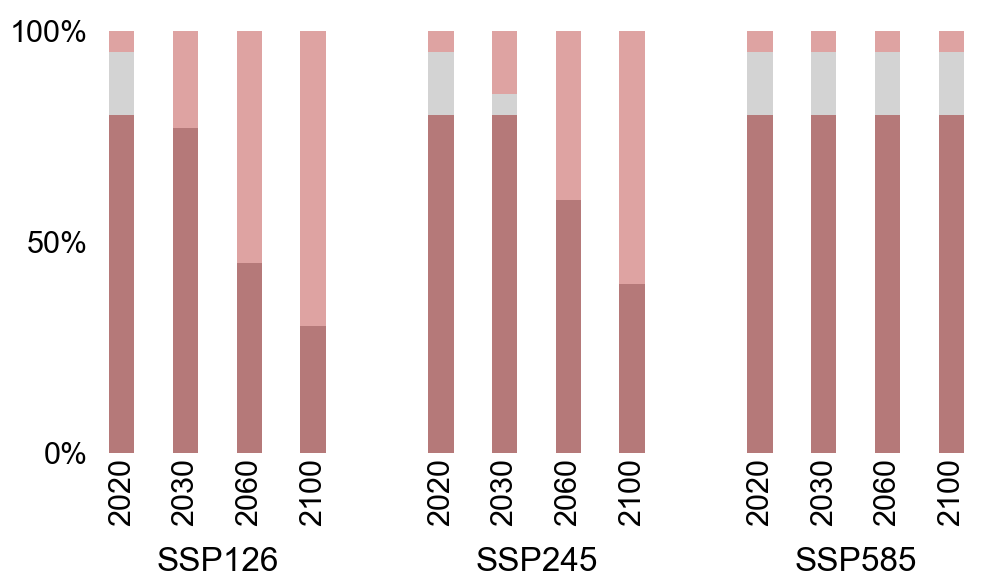

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取Excel文件中的指定范围数据
file_path = r'E:\dmy_file\China climate hvac\marketing_share.xls'
df = pd.read_excel(file_path, sheet_name='data', usecols="B:P", skiprows=12, nrows=4)

# 数据处理
x_labels = ['2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100']
categories = df.iloc[:, 0]  # B列为类别
data = df.iloc[:, 1:]       # 剩下的数据为堆积数据

# 将数据转为百分比
data_percent = data.divide(data.sum(axis=0), axis=1) * 100

# 颜色设置
colors = ["#B57979", "#D3D3D3", "#DEA3A2"]


# 绘制百分比堆积柱状图
fig, ax = plt.subplots(figsize=(10, 6))
data_percent.T.plot(kind='bar', stacked=True, color=colors, width=0.4, ax=ax)

# 设置y轴
ax.set_yticks([0, 50, 100])
ax.set_yticklabels(['0%', '50%', '100%'], fontname='Arial', fontsize=22)

# 设置x轴和堆积图样式
ax.set_xticklabels(x_labels, fontname='Arial', fontsize=22, rotation=90)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(False)
ax.legend().set_visible(False)
ax.set_frame_on(False)  # 移除边框
ax.tick_params(axis='x', length=0)  # 不显示x轴刻度线
ax.tick_params(axis='y', length=0)  # 不显示y轴刻度线
ax.grid(False)  # 不显示网格线
ax.legend().set_visible(False)  # 不显示图例
ax.set_title('')  # 不显示图表题


# 在x轴下方插入文字
for i, text in enumerate(['SSP126', 'SSP245', 'SSP585']):
    ax.text(1.5 + i * 5, -28, text, ha='center', fontname='Arial', fontsize=24)

# 调整图形布局，向上移动图形内容
plt.subplots_adjust(top=0.95, bottom=0.2)  # 上移内容，bottom 参数越大，内容越上移

plt.savefig(r'E:\dmy_file\China climate hvac\picture\new{fig_name}_polyon.png'.format(fig_name='HVAC_wintercold_urban'), dpi=150)

# 显示图形
plt.tight_layout()
plt.show()


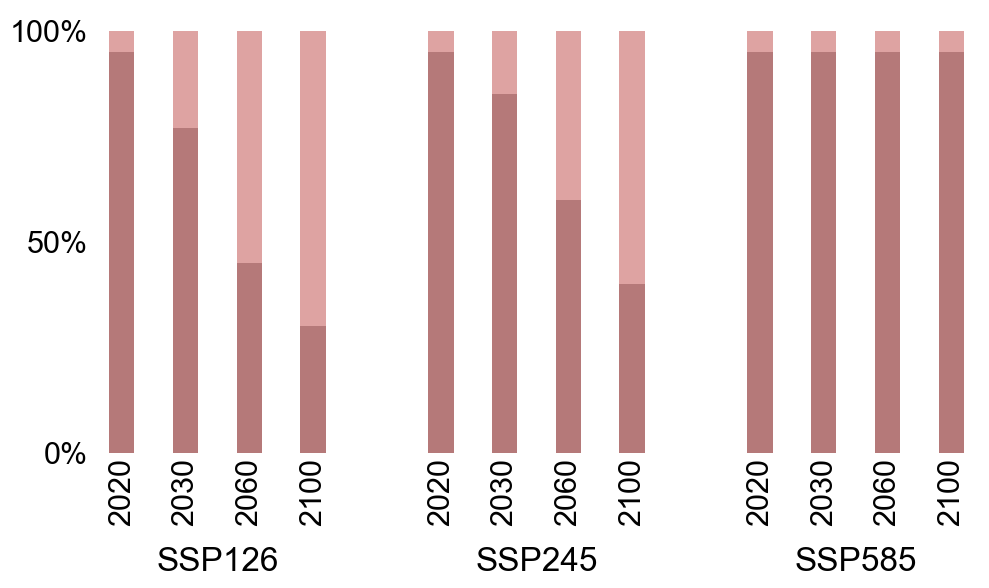

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取Excel文件中的指定范围数据
file_path = r'E:\dmy_file\China climate hvac\marketing_share.xls'
df = pd.read_excel(file_path, sheet_name='data', usecols="R:AF", skiprows=12, nrows=3)

# 数据处理
x_labels = ['2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100']
categories = df.iloc[:, 0]  # B列为类别
data = df.iloc[:, 1:]       # 剩下的数据为堆积数据

# 将数据转为百分比
data_percent = data.divide(data.sum(axis=0), axis=1) * 100

# 颜色设置
colors = ["#B57979", "#DEA3A2"]


# 绘制百分比堆积柱状图
fig, ax = plt.subplots(figsize=(10, 6))
data_percent.T.plot(kind='bar', stacked=True, color=colors, width=0.4, ax=ax)

# 设置y轴
ax.set_yticks([0, 50, 100])
ax.set_yticklabels(['0%', '50%', '100%'], fontname='Arial', fontsize=22)

# 设置x轴和堆积图样式
ax.set_xticklabels(x_labels, fontname='Arial', fontsize=22, rotation=90)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(False)
ax.legend().set_visible(False)
ax.set_frame_on(False)  # 移除边框
ax.tick_params(axis='x', length=0)  # 不显示x轴刻度线
ax.tick_params(axis='y', length=0)  # 不显示y轴刻度线
ax.grid(False)  # 不显示网格线
ax.legend().set_visible(False)  # 不显示图例
ax.set_title('')  # 不显示图表题


# 在x轴下方插入文字
for i, text in enumerate(['SSP126', 'SSP245', 'SSP585']):
    ax.text(1.5 + i * 5, -28, text, ha='center', fontname='Arial', fontsize=24)

# 调整图形布局，向上移动图形内容
plt.subplots_adjust(top=0.95, bottom=0.2)  # 上移内容，bottom 参数越大，内容越上移

plt.savefig(r'E:\dmy_file\China climate hvac\picture\new{fig_name}_polyon.png'.format(fig_name='HVAC_wintercold_rural'), dpi=150)

# 显示图形
plt.tight_layout()
plt.show()


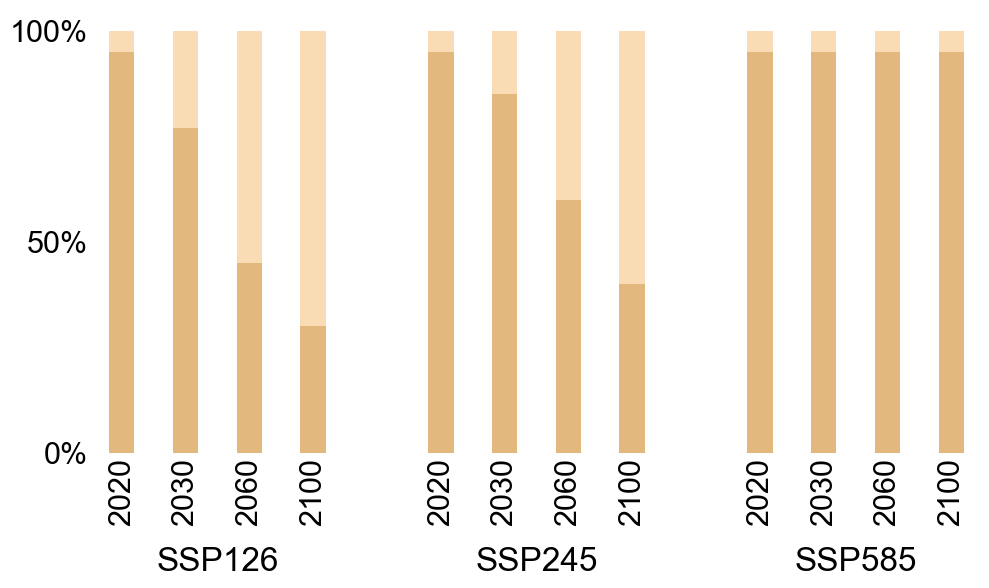

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取Excel文件中的指定范围数据
file_path = r'E:\dmy_file\China climate hvac\marketing_share.xls'
df = pd.read_excel(file_path, sheet_name='data', usecols="B:P", skiprows=17, nrows=3)

# 数据处理
x_labels = ['2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100', '', '2020', '2030', '2060', '2100']
categories = df.iloc[:, 0]  # B列为类别
data = df.iloc[:, 1:]       # 剩下的数据为堆积数据

# 将数据转为百分比
data_percent = data.divide(data.sum(axis=0), axis=1) * 100

# 颜色设置
colors = ["#E3B87F", "#FADCB4"]


# 绘制百分比堆积柱状图
fig, ax = plt.subplots(figsize=(10, 6))
data_percent.T.plot(kind='bar', stacked=True, color=colors, width=0.4, ax=ax)

# 设置y轴
ax.set_yticks([0, 50, 100])
ax.set_yticklabels(['0%', '50%', '100%'], fontname='Arial', fontsize=22)

# 设置x轴和堆积图样式
ax.set_xticklabels(x_labels, fontname='Arial', fontsize=22, rotation=90)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(False)
ax.legend().set_visible(False)
ax.set_frame_on(False)  # 移除边框
ax.tick_params(axis='x', length=0)  # 不显示x轴刻度线
ax.tick_params(axis='y', length=0)  # 不显示y轴刻度线
ax.grid(False)  # 不显示网格线
ax.legend().set_visible(False)  # 不显示图例
ax.set_title('')  # 不显示图表题


# 在x轴下方插入文字
for i, text in enumerate(['SSP126', 'SSP245', 'SSP585']):
    ax.text(1.5 + i * 5, -28, text, ha='center', fontname='Arial', fontsize=24)

# 调整图形布局，向上移动图形内容
plt.subplots_adjust(top=0.95, bottom=0.2)  # 上移内容，bottom 参数越大，内容越上移    

plt.savefig(r'E:\dmy_file\China climate hvac\picture\new{fig_name}_polyon.png'.format(fig_name='HVAC_winterwarm_urban'), dpi=150)

# 显示图形
plt.tight_layout()
plt.show()


生成图例

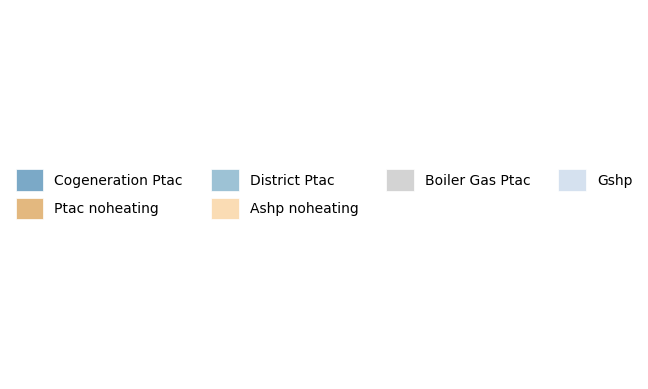

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 自定义颜色和标签
legend_elements = [
    mpatches.Patch(facecolor="#7BA9C7", edgecolor='white', label='Cogeneration Ptac', linewidth=0.5),
    mpatches.Patch(facecolor="#E3B87F", edgecolor='white', label='Ptac noheating', linewidth=0.5),
    mpatches.Patch(facecolor="#9DC2D5", edgecolor='white', label='District Ptac', linewidth=0.5),
    mpatches.Patch(facecolor="#FADCB4", edgecolor='white', label='Ashp noheating', linewidth=0.5),
    mpatches.Patch(facecolor="#D3D3D3", edgecolor='white', label='Boiler Gas Ptac', linewidth=0.5),
    mpatches.Patch(facecolor="#D5E1EF", edgecolor='white', label='Gshp', linewidth=0.5)
    
    
]

# 创建图例
fig, ax = plt.subplots()

# 添加图例，设置横向排列，图例边框颜色为白色
ax.legend(handles=legend_elements, loc='center', frameon=False, fontsize=10, ncol=4, handleheight=2, handlelength=2)

# 隐藏坐标轴
ax.axis('off')
plt.savefig(r'E:\dmy_file\China climate hvac\picture\new{fig_name}_polyon.png'.format(fig_name='legend_1'), dpi=150)
# 显示图例
plt.show()



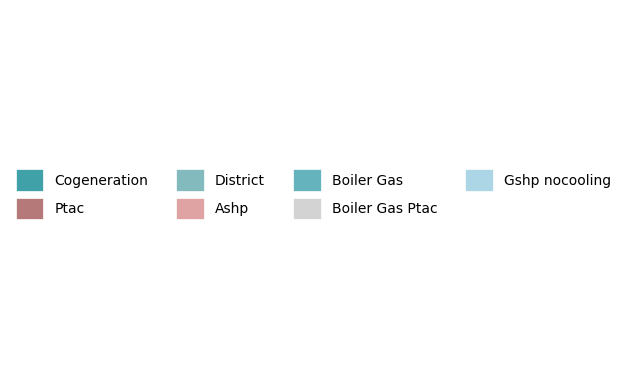

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 自定义颜色和标签
legend_elements = [
    mpatches.Patch(facecolor="#40A1A9", edgecolor='white', label='Cogeneration', linewidth=0.5),
    mpatches.Patch(facecolor="#B57979", edgecolor='white', label='Ptac', linewidth=0.5),
    mpatches.Patch(facecolor="#82BABE", edgecolor='white', label='District', linewidth=0.5),
    mpatches.Patch(facecolor="#DEA3A2", edgecolor='white', label='Ashp', linewidth=0.5),
    mpatches.Patch(facecolor="#64b3bd", edgecolor='white', label='Boiler Gas', linewidth=0.5),#A1CED7
    mpatches.Patch(facecolor="#D3D3D3", edgecolor='white', label='Boiler Gas Ptac', linewidth=0.5),
    mpatches.Patch(facecolor="#ACD6E5", edgecolor='white', label='Gshp nocooling', linewidth=0.5)
      
]

# 创建图例
fig, ax = plt.subplots()

# 添加图例，设置横向排列，图例边框颜色为白色
ax.legend(handles=legend_elements, loc='center', frameon=False, fontsize=10, ncol=4, handleheight=2, handlelength=2)

# 隐藏坐标轴
ax.axis('off')
plt.savefig(r'E:\dmy_file\China climate hvac\picture\new{fig_name}_polyon.png'.format(fig_name='legend_2'), dpi=150)
# 显示图例
plt.show()

